### Federated Learning Unfair Repartition

In this notebook, we will train the same model (MobilenetV2) and using the same federated learning algorythme but we will split the dataset in an unfair way.
All the subset will have approximatively the same size but they will be unequally balanced

In [1]:
# This is for Kaggle notebook.
# import module we'll need to import our custom module
from shutil import copytree

# copy our file into the working directory (make sure it has .py suffix)
copytree(src = "../input/myfedprox/MyFedProx/", dst = "../working/MyFedProx")

'../working/MyFedProx'

In [2]:
from MyFedProx.CNN import CNN
from MyFedProx.federated_learning import *
from MyFedProx.dataset_splits import *


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch
import numpy as np
import pandas as pd
from torchvision.models import mobilenet_v2
from sklearn.model_selection import train_test_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# here we will split the dataset into 3 clients where the class repartition is unfair
df_train = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv")
# first we will balance the dataframe the same way we did in the other notebooks
# so we have the same dataset 
df_min = df_train[df_train["target"] == 1].sample(frac=1)
df_maj = df_train[df_train["target"] == 0]
df_maj_downsampled = df_maj.sample(n=len(df_min))

In [5]:
# extract 20% of the data for the test set
df_min, df_min_test = train_test_split(df_min, test_size=0.2, random_state=42)
df_maj_downsampled, df_maj_downsampled_test = train_test_split(df_maj_downsampled, test_size=0.2, random_state=42)
df_test = pd.concat([df_min_test, df_maj_downsampled_test])

In [10]:
positive_ratio = np.array([0.05, 0.75, 0.2])
negative_ratio = np.array([0.33, 0.33, 0.33])


first_df = pd.concat([df_min.iloc[:int(len(df_min)*positive_ratio[0])], df_maj_downsampled.iloc[:int(len(df_maj_downsampled)*negative_ratio[0])]])
second_df = pd.concat([df_min.iloc[int(len(df_min)*positive_ratio[0]):int(len(df_min)*(positive_ratio[0]+positive_ratio[1]))], df_maj_downsampled.iloc[int(len(df_maj_downsampled)*negative_ratio[0]):int(len(df_maj_downsampled)*(negative_ratio[0]+negative_ratio[1]))]])
third_df = pd.concat([df_min.iloc[int(len(df_min)*(positive_ratio[0]+positive_ratio[1])):], df_maj_downsampled.iloc[int(len(df_maj_downsampled)*(negative_ratio[0]+negative_ratio[1])):]])
dfs = [first_df, second_df, third_df]

In [11]:
# let's check the class repartition for each client
def print_class_repartition(df):
    nb_pos = len(df[df["target"] == 1])
    nb_pos_ratio = nb_pos/len(df)
    print("Positive ratio: ", nb_pos_ratio)


for i, df in enumerate(dfs):
    print("Client ", i)
    print_class_repartition(df)

print("Test set")
print_class_repartition(df_test)


Client  0
Positive ratio:  0.12994350282485875
Client  1
Positive ratio:  0.6944444444444444
Client  2
Positive ratio:  0.3715415019762846
Test set
Positive ratio:  0.5


We keep a balanced test dataset to be able to compare the result with the other models

In [15]:
# we will now create the datasets
train_datasets = [SIIM_ISIC_Dataset(df, "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/", device, resnet50=True) for df in dfs]
train_loaders = [DataLoader(dataset, batch_size=32, shuffle=True) for dataset in train_datasets]
test_dataset = SIIM_ISIC_Dataset(df_test, "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/", device, resnet50=True)
test_loaders = [DataLoader(test_dataset, batch_size=32, shuffle=True) for _ in range(3)]

In [16]:
model = mobilenet_v2(pretrained=True).to(device)
model.classifier[1] = torch.nn.Linear(1280, 2).to(device)
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True
#model = CNN().to(device)

In [17]:
model, loss_acc, hist_acc = FedProx(model, train_loaders,n_iter=10,  testing_sets=test_loaders,  epochs=2, mu=0.3)

Clients' weights: [0.18950749464668093, 0.5396145610278372, 0.2708779443254818]
====> i: 0 Loss: 0.7553354185194223 Server Test Accuracy: 46.699701678288406
====> i: 1 Loss: 0.8192742121040949 Server Test Accuracy: 61.769066051721296
====> i: 2 Loss: 0.9113761535038019 Server Test Accuracy: 60.45590146232544
====> i: 3 Loss: 0.7833243362781067 Server Test Accuracy: 68.10748732590274
====> i: 4 Loss: 0.8297042750954883 Server Test Accuracy: 66.98878090741046
====> i: 5 Loss: 0.7562520015163136 Server Test Accuracy: 68.14180347370925
====> i: 6 Loss: 0.6704061515709062 Server Test Accuracy: 70.0882153772946
====> i: 7 Loss: 0.6878540389542918 Server Test Accuracy: 72.7415399256941
====> i: 8 Loss: 0.8969819330684122 Server Test Accuracy: 70.77911381979904
====> i: 9 Loss: 0.7163211435909189 Server Test Accuracy: 73.15516389392192
====> i: 10 Loss: 1.0393375020466218 Server Test Accuracy: 68.84963121579824


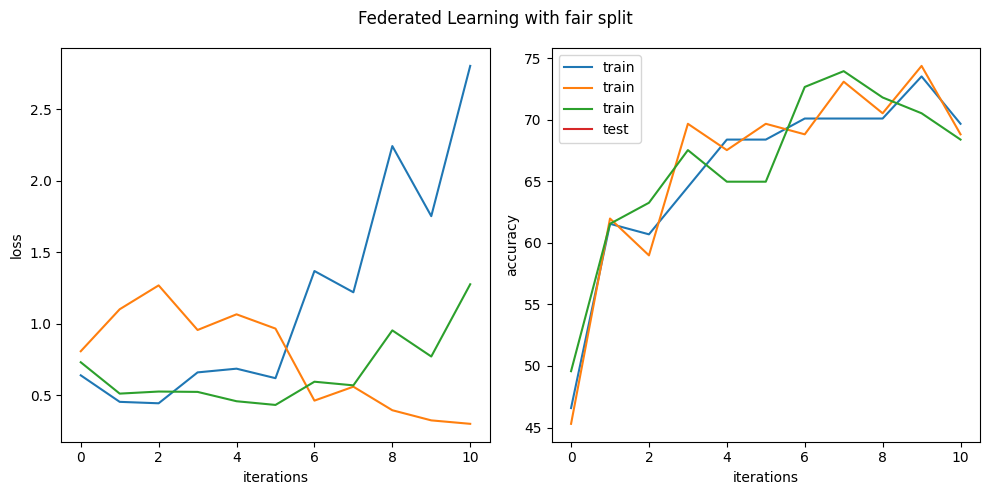

In [18]:
plot_acc_loss("Federated Learning with fair split", hist_acc, [], loss_acc)

We achieve a 73% test accuracy which is a bit less than the previous model

In [19]:
torch.save(model.state_dict(), "model_unfair_repartition_split.pt")